In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import time
import pyro
from pyro.infer import HMC, MCMC, NUTS
from ex2mcmc.samplers import mala, i_sir, ex2_mcmc
import ot
import jax
import gc

from ex2mcmc.sampling_utils.adaptive_mc import CISIR, Ex2MCMC, FlowMCMC
from ex2mcmc.sampling_utils.adaptive_sir_loss import MixKLLoss
from ex2mcmc.sampling_utils.distributions import (
    Banana,
    CauchyMixture,
    Distribution,
    Funnel,
    HalfBanana,
    IndependentNormal,
)
from ex2mcmc.sampling_utils.ebm_sampling import MALA
from ex2mcmc.sampling_utils.flows import RNVP
from ex2mcmc.sampling_utils.metrics import ESS, acl_spectrum
from ex2mcmc.sampling_utils.total_variation import (
    average_total_variation,
)
%matplotlib inline


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
def sample_nuts(target, proposal, device = 'cpu', num_samples=1000, burn_in=1000, batch_size=1, rand_seed = 42):
    def true_target_energy(z):
        return -target(z)

    def energy(z):
        z = z["points"]
        return true_target_energy(z).sum()
    start_time = time.time()
    # kernel = HMC(potential_fn=energy, step_size = 0.1, num_steps = K, full_mass = False)
    kernel_true = NUTS(potential_fn=energy, full_mass=False)
    #kernel_true = HMC(potential_fn=energy, full_mass=False)
    pyro.set_rng_seed(rand_seed)
    init_samples = proposal.sample((batch_size,)).to(device)
    print(init_samples.shape) 
    #init_samples = torch.zeros_like(init_samples)
    dim = init_samples.shape[-1]
    init_params = {"points": init_samples}
    mcmc_true = MCMC(
        kernel=kernel_true,
        num_samples=num_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()
    q_true = mcmc_true.get_samples(group_by_chain=True)["points"].cpu()
    samples_true = np.array(q_true.view(-1, batch_size, dim))
    end_time = time.time()
    return end_time-start_time, samples_true

In [3]:
def plot_learned_density(
    flow,
    proposal,
    fig=None,
    device="cpu",
    xlim=[-1, 1],
    ylim=[-1, 1],
    rest=0.0,
):
    if fig is None:
        fig = plt.figure()
    n_pts = 200
    z = proposal.sample((n_pts**2,))
    x = np.linspace(*xlim, n_pts)
    y = np.linspace(*ylim, n_pts)
    xx, yy = np.meshgrid(x, y)
    zz = np.stack([xx, yy], -1)
    z[:, :2] = torch.FloatTensor(zz).view(-1, 2).to(device)
    z[:, 2:] = torch.FloatTensor([rest] * n_pts**2)[:, None]

    inv, minus_log_jac = flow.inverse(z)
    minus_log_jac = minus_log_jac.reshape(n_pts, n_pts)
    inv = inv.reshape(n_pts, n_pts, -1)
    vals = (proposal(inv) + minus_log_jac).exp().detach()

    im = plt.contourf(xx, yy, vals.reshape(n_pts, n_pts), cmap="GnBu")
    fig.colorbar(im)
    return fig

def compute_metrics(
    xs_true,
    xs_pred,
    name=None,
    n_samples=1000,
    scale=1.0,
    trunc_chain_len=None,
    ess_rar=1,
):
    metrics = dict()
    key = jax.random.PRNGKey(0)
    n_steps = 25
    # n_samples = 100

    ess = ESS(
        acl_spectrum(
            xs_pred[::ess_rar] - xs_pred[::ess_rar].mean(0)[None, ...],
        ),
    ).mean()
    metrics["ess"] = ess

    xs_pred = xs_pred[-trunc_chain_len:]
    print(xs_true.shape)
    print(xs_pred.shape)

    tracker = average_total_variation(
        key,
        xs_true,
        xs_pred,
        n_steps=n_steps,
        n_samples=n_samples,
    )

    metrics["tv_mean"] = tracker.mean()
    metrics["tv_conf_sigma"] = tracker.std_of_mean()

    mean = tracker.mean()
    std = tracker.std()

    metrics["emd"] = 0
    #Cost_matr_isir = ot.dist(x1 = isir_res[j][i], x2=gt_samples[i], metric='sqeuclidean', p=2, w=None)
    for b in range(xs_pred.shape[1]):
        M = ot.dist(xs_true / scale, xs_pred[:, b,:] / scale)
        emd = ot.lp.emd2([], [], M, numItermax = 1e6)
        metrics["emd"] += emd / xs_pred.shape[1]

    if name is not None:
        print(f"===={name}====")
    print(
        f"TV distance. Mean: {mean:.3f}, Std: {std:.3f}. \nESS: {ess:.3f} \nEMD: {emd:.3f}",
    )

    return metrics

In [4]:
def plot_metrics(metrics, ndims, savepath=None, scale=1.0, colors=None):
    axs_names = ["Sliced TV", "ESS", "EMD ratio"]  # (on scaled data)']
    ncols = len(axs_names)

    figs = []
    axs = []
    for _ in range(ncols):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
        figs.append(fig)
        axs.append(ax)

    mala_emd = metrics['MALA']['emd']
    
    for (name, res), color in zip(metrics.items(), colors):
        for k, v in res.items():
            res[k] = np.array(v)

        arr = res["tv_mean"]
        axs[0].plot(ndims, arr, label=name, marker="o", color=color)

        axs[0].fill_between(
            ndims,
            res["tv_mean"] - 1.96 * res["tv_conf_sigma"],
            res["tv_mean"] + 1.96 * res["tv_conf_sigma"],
            alpha=0.2,
        )

        arr = res["ess"]
        axs[1].plot(ndims, arr, label=name, marker="o", color=color)

        if name != 'MALA':
            arr = mala_emd / res["emd"]
            axs[2].plot(ndims, arr, label=name, marker="o", color=color)
        #axs[2].set_yscale("log")

    for ax, fig, name in zip(axs, figs, axs_names):
        ax.grid()
        ax.set_title(name.split(' ')[0])
        ax.set_xlabel("dim")
        if name == "EMD ratio":
            ax.legend()

        fig.tight_layout()

        if savepath is not None:
            fig.savefig(Path(savepath, f"{name}.pdf"))

In [10]:
n_steps = 1
dist = "Funnel"
dim = 100
scale_proposal = 1.
scale_isir = 3.
dist_class = "Funnel"
a = 2.0
b = 0.5
target = Funnel(
                dim=dim,
                device=device,
                a = a,
                b = b
                #**dist_params.dict,
)

In [11]:
loc_proposal = torch.zeros(dim).to(device)
scale_proposal = scale_proposal * torch.ones(dim).to(device)
scale_isir = scale_isir * torch.ones(dim).to(device)

proposal = IndependentNormal(
    dim=dim,
    loc=loc_proposal,
    scale=scale_proposal,
    device=device,
)

proposal_ex2 = IndependentNormal(
    dim=dim,
    loc=loc_proposal,
    scale=scale_isir,
    device=device,
)

### Generate ground-truth samples

In [12]:
N_samples = 1*10**3
np.random.seed(42)
True_samples = np.random.randn(N_samples,dim)
True_samples[:,0] *= a 
for k in range(1,dim):
    True_samples[:,k] *= np.exp(True_samples[:,0]/2) 

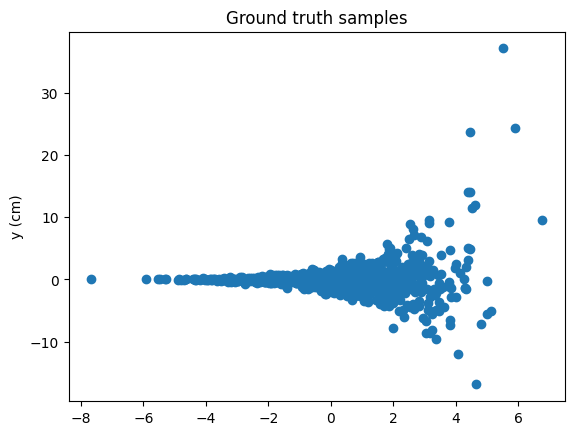

In [13]:
fig,ax=plt.subplots(1,1)
#cp = ax.contourf(X, Y, dens_vals)
#fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(True_samples[:,0],True_samples[:,1])
ax.set_title('Ground truth samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Sample with NUTS

In [14]:
#samples to compute ground-truth metrics
Nuts_samples_ground_truth = 2000
#Nuts_samples_comparison
trunc_chain_len = 1000
#nuts samples burn_in
nuts_burn_in = 500
#nuts batch size
nuts_batch = 1

### Generate ground-truth samples (with NUTS)

In [15]:
#samples_true = sample_nuts(
#                target,
#                proposal,
#                num_samples=Nuts_samples_ground_truth,#config.trunc_chain_len,
#                batch_size=nuts_batch, #config.batch_size
#)[:, 0, :]
#print(samples_true.shape)

In [16]:
rand_seed = 45
time_nuts, sample_nuts_ref = sample_nuts(
                target,
                proposal,
                device,
                num_samples=1000,
                batch_size=nuts_batch,
                burn_in=nuts_burn_in,
                rand_seed = rand_seed
)
print(sample_nuts_ref.shape)

torch.Size([1, 100])


Sample: 100%|██████████| 1500/1500 [00:42, 35.26it/s, step size=6.74e-02, acc. prob=0.880] 

(1000, 1, 100)


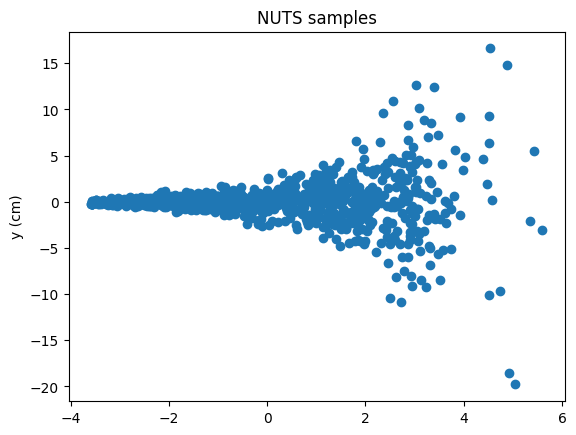

In [17]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_nuts_ref[:,0,0],sample_nuts_ref[:,0,1])
ax.set_title('NUTS samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

In [18]:
metrics = compute_metrics(
                    True_samples,
                    sample_nuts_ref,
                    name="NUTS",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(1000, 100)
(1000, 1, 100)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.074, Std: 0.029. 
ESS: 0.197 
EMD: 1014.357


### Sample with Ex2MCMC

In [19]:
params = {
      "N": 2000,
      "grad_step": 0.1,
      "adapt_stepsize": True, #True
      "corr_coef": 0.0,
      "bernoulli_prob_corr": 0.0, #0.75
      "mala_steps": 3
}
        
n_steps_ex2 = 5000
batch_size = 1

In [20]:
distr = torch.distributions.Normal(torch.zeros(1).to(device), torch.ones(1).to(device))
logprob1 = distr.log_prob(torch.ones(1).to(device))
print(logprob1)

tensor([-1.4189])


In [21]:
gc.collect()
torch.cuda.empty_cache()

In [22]:
mcmc = Ex2MCMC(**params, dim=dim)
pyro.set_rng_seed(43)
start = proposal_ex2.sample((batch_size,)).to(device)
print(start)
# s = time.time()
out = mcmc(start, target, proposal_ex2, n_steps = n_steps_ex2)
print(out[1])
if isinstance(out, tuple):
    sample = out[0]
else:
    sample = out
sample = np.array(
    [_.detach().numpy() for _ in sample],
).reshape(-1, batch_size, dim)
sample_ex2_final = sample[:,0,:]
print(sample_ex2_final.shape)

tensor([[-0.0498, -1.4004,  6.2727,  1.8447, -1.6863, -1.2428, -3.9003, -0.3036,
         -3.2998, -1.4060, -2.5201,  2.0605, -0.2033, -0.2658, -0.9371, -1.0657,
          2.1427,  1.2595, -5.3017, -1.4988,  0.9248, -0.8840, -2.2987, -2.9885,
          2.3344, -2.0567, -2.1977,  0.9013, -1.0890,  4.7467, -1.3289,  5.5386,
         -2.1344,  3.1276, -2.2854, -1.4491, -2.3312, -1.3452, -3.5005,  1.5017,
          3.9753, -3.4880, -6.3559,  1.6409, -3.5003, -3.0598,  4.8848,  1.0426,
         -0.3574, -4.6246,  1.9262,  4.5048, -0.5864,  2.2313,  4.0834,  2.3789,
          1.4331,  2.7745,  2.6524,  2.3427,  1.3991, -6.7856,  1.6121, -2.4007,
          5.0146, -1.0789, -6.4539, -4.0776, -2.1608, -1.7038, -1.6314,  5.5476,
         -0.0256, -1.2498,  1.4234, -1.3186, -2.2680,  3.4088,  3.8268,  0.4925,
          8.1480,  2.4271, -3.2091, -0.5971,  2.1426, -1.8414,  2.4056,  5.6965,
         -3.4502,  0.1139, -2.0359, -2.2649,  1.7483, -5.4082,  6.6041, -0.5617,
         -1.2954, -4.4075,  

100%|██████████| 5000/5000 [00:41<00:00, 120.31it/s]


tensor([0.4993])
(5000, 100)


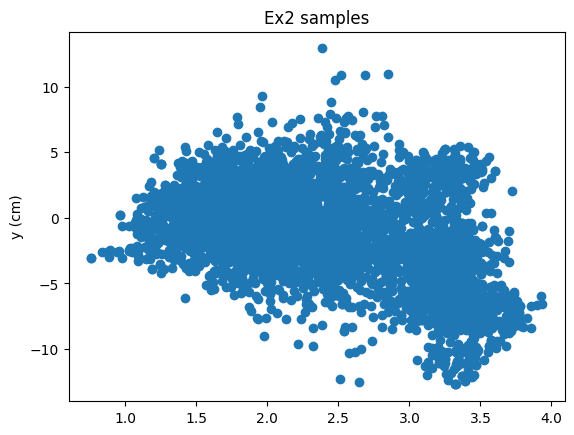

In [23]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1])
ax.set_title('Ex2 samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Sample with Flex2MCMC (adaptive version)

In [24]:
params_flex = {
      "N": 200,
      "grad_step": 0.2,
      "adapt_stepsize": True,
      "corr_coef": 0.0,
      "bernoulli_prob_corr": 0.0,
      "mala_steps": 0,
    "flow": {
      "num_flows": 4, # number of normalizing layers 
      "lr": 1e-3, # learning rate 
      "batch_size": 100,
      "n_steps": 1000,
    }
}
batch_size = 1
torch.cuda.empty_cache()

In [27]:
pyro.set_rng_seed(42)
mcmc = Ex2MCMC(**params_flex, dim=dim)
verbose = mcmc.verbose
mcmc.verbose = False
flow = RNVP(params_flex["flow"]["num_flows"], dim=dim, device = device)
flow_mcmc = FlowMCMC(
    target,
    proposal,
    device,
    flow,
    mcmc,
    batch_size=params_flex["flow"]["batch_size"],
    lr=params_flex["flow"]["lr"],
)
flow.train()
out_samples, nll = flow_mcmc.train(
    n_steps=params_flex["flow"]["n_steps"],
)
assert not torch.isnan(
    next(flow.parameters())[0, 0],
).item()
gc.collect()
torch.cuda.empty_cache()
flow.eval()
mcmc.flow = flow
mcmc.verbose = verbose

In [28]:
#sample from a normalizing flow
n_steps_flex2 = 1000
batch_size = 1
pyro.set_rng_seed(42)
start = proposal.sample((batch_size,))
mcmc.N = 200
mcmc.mala_steps = 0
mcmc.grad_step = 0.1
# s = time.time()
out = mcmc(start, target, proposal, n_steps = n_steps_flex2)
if isinstance(out, tuple):
    sample = out[0]
else:
    sample = out
sample = np.array(
    [_.detach().numpy() for _ in sample],
).reshape(-1, batch_size, dim)
sample_flex2_new = sample
#resample with 0 mala steps
torch.cuda.empty_cache()
mcmc.mala_steps = 3
out_new = mcmc(start, target, proposal, n_steps = n_steps_flex2)
print(out_new[1])
out_new = out_new[0]
out_new = np.array(
    [_.detach().numpy() for _ in out_new],
).reshape(-1, batch_size, dim)
sample_flex2_final = out_new
print(sample_flex2_final.shape)

100%|██████████| 1000/1000 [00:10<00:00, 97.59it/s]

tensor([0.4960])
(1000, 1, 100)


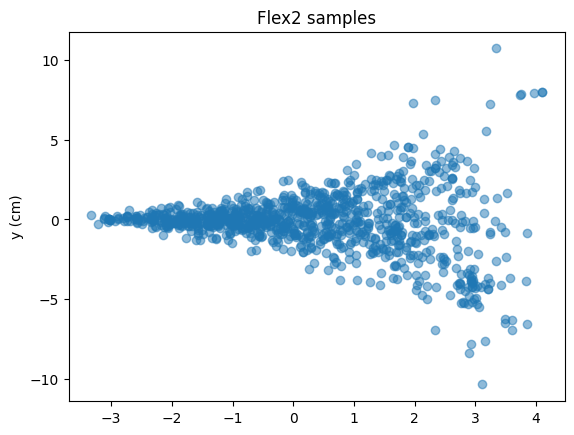

In [29]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],alpha = 0.5)
ax.set_title('Flex2 samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
#ax.set_yscale('log')
plt.show()

In [30]:
metrics = compute_metrics(
                    True_samples,
                    sample_flex2_final,
                    name="Flex2",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(1000, 100)
(1000, 1, 100)


  0%|          | 0/25 [00:00<?, ?it/s]

====Flex2====
TV distance. Mean: 0.062, Std: 0.016. 
ESS: 0.229 
EMD: 923.894


In [31]:
dim = 200
loc_proposal = torch.zeros(dim).to(device)
scale_proposal = 1.0 * torch.ones(dim).to(device)
#scale_isir = scale_isir * torch.ones(dim).to(device)

proposal = IndependentNormal(
        dim=dim,
        loc=loc_proposal,
        scale=scale_proposal,
        device=device,
)

n_samples = 2000
pyro.set_rng_seed(42)
sample_2 = proposal.sample((n_samples,))
sample_2 = sample_2.unsqueeze(1).cpu().numpy()
print(sample_2.shape)
sample_1 = proposal.sample((n_samples,)).cpu().numpy()
metrics = compute_metrics(
                    sample_1,
                    sample_2,
                    name="Gaussian noise",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(2000, 1, 200)
(2000, 200)
(1000, 1, 200)


  0%|          | 0/25 [00:00<?, ?it/s]

====Gaussian noise====
TV distance. Mean: 0.035, Std: 0.009. 
ESS: 0.832 
EMD: 311.477


In [32]:
print(np.sum(True_samples[:,0] < -2))
print(np.sum(sample_nuts_ref[:,0,0] < -2))
print(np.sum(sample_flex2_final[:,0,0] < -2))

139
222
90


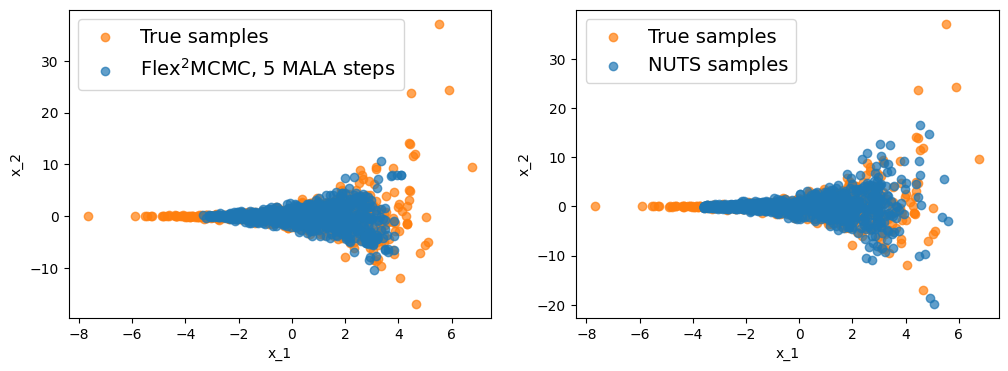

In [33]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e', alpha = 0.7, label = "True samples")
ax[0].scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],c='#1f77b4', alpha = 0.7, label = "Flex$^2$MCMC, 5 MALA steps")
#ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1],c='#ff7f0e',label = "Ex2 samples")
#ax[0].set_title('All samples')
ax[0].set_xlabel('x_1')
ax[0].set_ylabel('x_2')
ax[0].legend(fontsize=14)
#ax.set_yscale('log')
#plt.legend()
#plt.show()
#ax.scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],c='#1f77b4',label = "Flex samples")
#ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1],c='#ff7f0e',label = "Ex2 samples")
ax[1].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e', alpha = 0.7, label = "True samples")
ax[1].scatter(sample_nuts_ref[:,0,0],sample_nuts_ref[:,0,1],c='#1f77b4', alpha = 0.7, label = "NUTS samples")
#ax[1].set_title('All samples')
ax[1].set_xlabel('x_1')
ax[1].set_ylabel('x_2')
#ax.set_yscale('log')
plt.legend(fontsize=14)
#plt.savefig(Path(
#        "./",
#        f"flow_funnel_samples_dim_{dim}_var_2_N_{mcmc.N}_mala_{mcmc.mala_steps}.pdf",
#        ), format="pdf", bbox_inches="tight") 
# plt.savefig("funnel_visualize_d_100.png",format="png", bbox_inches="tight")
plt.show()